In [50]:
# %% Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer


from category_encoders import TargetEncoder
import joblib
import streamlit as st


In [2]:
import sklearn
print(sklearn.__version__)
from sklearn.impute import SimpleImputer
print("SimpleImputer imported successfully!")


1.6.1
SimpleImputer imported successfully!


In [3]:
data = pd.read_csv('Salary_Data.csv')
print("Data Loaded Successfully!")
print(data.head())

Data Loaded Successfully!
    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


In [70]:
import sklearn
print(sklearn.__file__)


C:\Users\isahi\AppData\Roaming\Python\Python313\site-packages\sklearn\__init__.py


In [4]:
# Step 1: Remove rows where 'Education Level' is NaN
data = data[data['Education Level'].notna()]

# Step 2: Standardize the 'PhD' format
data['Education Level'] = data['Education Level'].replace('phD', 'PhD')
data['Education Level'] = data['Education Level'].replace("Master's", "Master's Degree")
data['Education Level'] = data['Education Level'].replace("Bachelor's", "Bachelor's Degree")

# Display the cleaned data
print("Cleaned Dataset:")
print(data['Education Level'].unique())


Cleaned Dataset:
["Bachelor's Degree" "Master's Degree" 'PhD' 'High School']


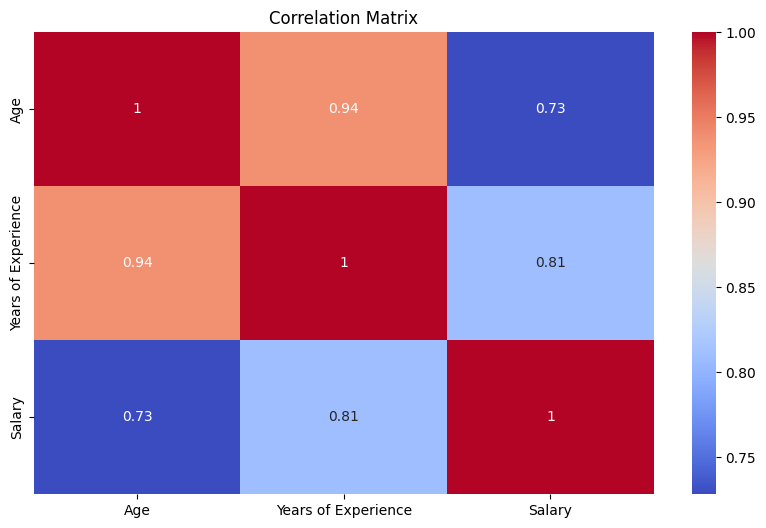

In [6]:
# %% Exploratory Data Analysis (EDA)
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

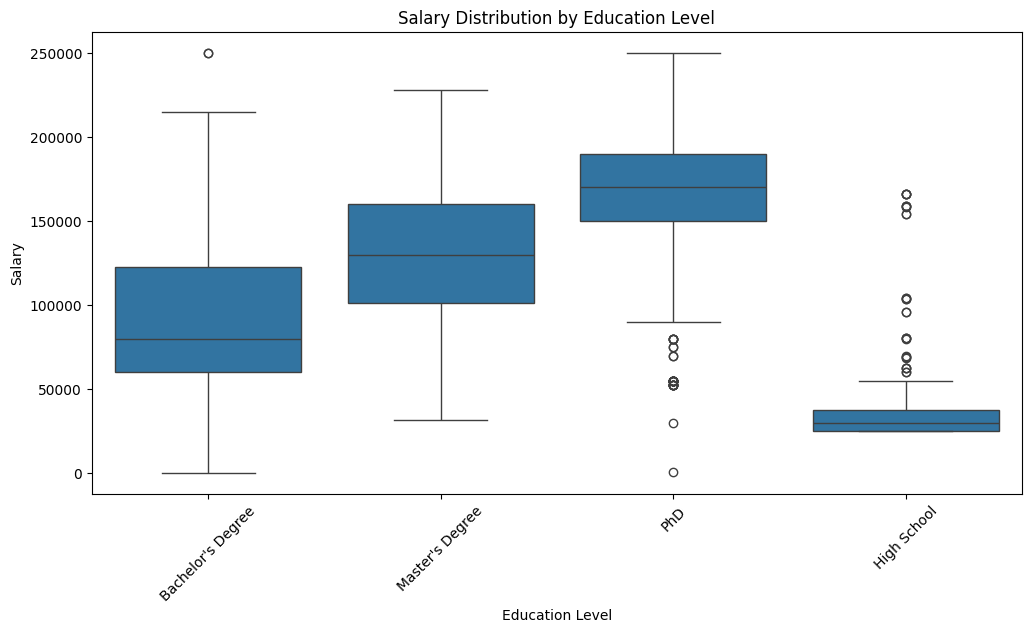

In [7]:
# Box plot for categorical feature 'Education Level'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Education Level', y='Salary', data=data)
plt.title("Salary Distribution by Education Level")
plt.xticks(rotation=45)
plt.show()

In [8]:
# %% Split Data into Train & Test Sets
X = data[['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience']]
y = data['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# %% Preprocessing Pipeline
# Define numerical and categorical features
numeric_features = ['Age', 'Years of Experience']
categorical_features = ['Gender', 'Education Level', 'Job Title']


In [10]:
# Pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [11]:
# Pipeline for categorical features using TargetEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

In [12]:
# Combine numerical and categorical transformers in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [13]:
# %% Feature Selection & Model Pipeline
# Use Lasso as the estimator for feature selection
lasso = Lasso(alpha=0.1, random_state=42)

# Create the full pipeline: preprocessing -> feature selection -> regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(lasso)),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

In [15]:
print(y_train.isnull().sum())

2


In [16]:
X_train = X_train[~y_train.isnull()]
y_train = y_train[~y_train.isnull()]


In [17]:
# Hyperparameter tuning for Gradient Boosting Regressor (example)
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('target_encoder',
                                                                                          TargetEncoder())]),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('feature_selection',
                                        SelectFromModel(estimator=Lasso(alpha=0.1,
                                                                        random_state=42))),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__learning_rate': [0.05, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='r2')

In [24]:
# Retrieve the best model
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Years of Experience']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder())]),
                                

In [25]:
# %% Model Evaluation
# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {np.mean(cv_scores):.3f}")

Cross-Validation R² Scores: [0.95999666 0.96524421 0.9707461  0.96808453 0.9689272 ]
Mean CV R²: 0.967


In [26]:
print(f"Number of NaN values in y_test: {np.isnan(y_test).sum()}")
print(f"Number of NaN values in y_pred: {np.isnan(y_pred).sum()}")


Number of NaN values in y_test: 1
Number of NaN values in y_pred: 0


In [27]:
mask = ~np.isnan(y_test) & ~np.isnan(y_pred)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]


In [28]:
print(f"Number of NaN values in y_test: {np.isnan(y_test).sum()}")
print(f"Number of NaN values in y_pred: {np.isnan(y_pred).sum()}")


Number of NaN values in y_test: 1
Number of NaN values in y_pred: 0


In [32]:
# Remove NaN values from y_test
mask = ~np.isnan(y_test)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

In [33]:
print(f"Number of NaN values in y_test: {np.isnan(y_test_clean).sum()}")
print(f"Number of NaN values in y_pred: {np.isnan(y_pred_clean).sum()}")


Number of NaN values in y_test: 0
Number of NaN values in y_pred: 0


In [34]:


# Test Set Evaluation
print("\nTest Set Evaluation:")
print(f"R² Score: {r2_score(y_test_clean, y_pred_clean):.3f}")
print(f"MSE: {mean_squared_error(y_test_clean, y_pred_clean):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_clean, y_pred_clean)):.2f}")



Test Set Evaluation:
R² Score: 0.971
MSE: 81519685.62
RMSE: 9028.83


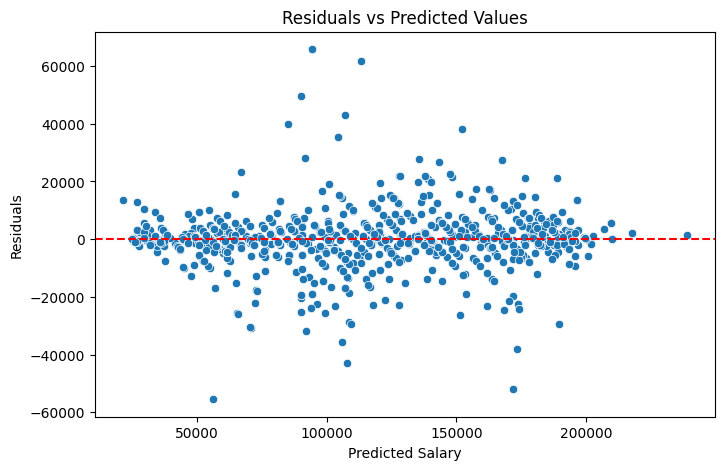

In [36]:
# %% Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.show()

In [37]:
# %% Feature Importance (For Tree-based Models)
# Use the ColumnTransformer's get_feature_names_out() to get names for all features
all_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get boolean mask of features selected by SelectFromModel
selected_mask = best_model.named_steps['feature_selection'].get_support()

# Create list of feature names that were actually used by the regressor
important_features = [all_feature_names[i] for i in range(len(all_feature_names)) if selected_mask[i]]

# Get feature importances from the regressor
importances = best_model.named_steps['regressor'].feature_importances_

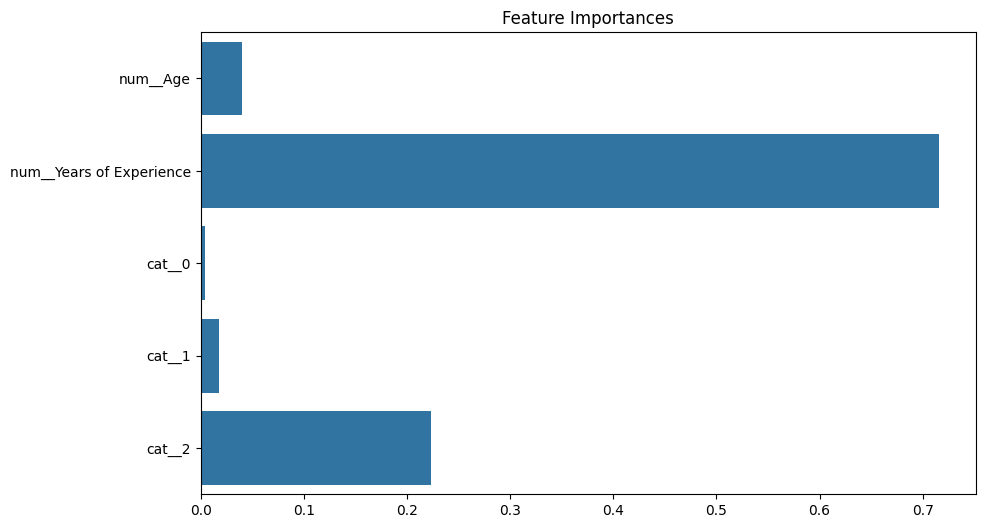

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=important_features)
plt.title("Feature Importances")
plt.show()

In [58]:
model = joblib.load('salary_predictor.pkl')

In [ ]:
test_cases = [
    {   # Case 1: Junior Data Analyst
        'Age': 25,
        'Gender': 'Female',
        'Education Level': "Bachelor's",
        'Job Title': 'Data Analyst',
        'Years of Experience': 2
    },
    {   # Case 2: Senior Software Engineer
        'Age': 35,
        'Gender': 'Male',
        'Education Level': "Master's",
        'Job Title': 'Senior Software Engineer',
        'Years of Experience': 10
    },
    {   # Case 3: Mid-level Manager
        'Age': 42,
        'Gender': 'Male',
        'Education Level': "PhD",
        'Job Title': 'Engineering Manager',
        'Years of Experience': 15
    },
    {   # Case 4: Entry-level different field
        'Age': 22,
        'Gender': 'Other',
        'Education Level': "High School",
        'Job Title': 'Marketing Assistant',
        'Years of Experience': 1
    },
    {   # Case 5: Complex Case with all features
        'Age': 30,
        'Gender': 'Male',
        'Education Level': "PhD",
        'Job Title': 'Marketing Assistant',
        'Years of Experience': 5
    }
]

# Function to predict and display results
def predict_and_display(test_case):
    input_df = pd.DataFrame([test_case])
    prediction = model.predict(input_df)[0]
    
    print("\n" + "="*50)
    print(f"Test Case: {test_case['Job Title']}")
    print("-"*50)
    print(f"• Age: {test_case['Age']}")
    print(f"• Gender: {test_case['Gender']}")
    print(f"• Education: {test_case['Education Level']}")
    print(f"• Experience: {test_case['Years of Experience']} years")
    print("-"*50)
    print(f"PREDICTED SALARY: ${prediction:,.2f}")
    print("="*50)

# Run all test cases
for case in test_cases:
    predict_and_display(case)

print("\nTesting complete!")





Test Case: Data Analyst
--------------------------------------------------
• Age: 25
• Gender: Female
• Education: Bachelor's
• Experience: 2 years
--------------------------------------------------
PREDICTED SALARY: $108,372.76

Test Case: Senior Software Engineer
--------------------------------------------------
• Age: 35
• Gender: Male
• Education: Master's
• Experience: 10 years
--------------------------------------------------
PREDICTED SALARY: $146,733.21

Test Case: Engineering Manager
--------------------------------------------------
• Age: 42
• Gender: Male
• Education: PhD
• Experience: 15 years
--------------------------------------------------
PREDICTED SALARY: $132,069.64

Test Case: Marketing Assistant
--------------------------------------------------
• Age: 22
• Gender: Other
• Education: High School
• Experience: 1 years
--------------------------------------------------
PREDICTED SALARY: $49,948.63

Test Case: Marketing Assistant
----------------------------------